In [1]:
import os
import sys

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
    
import tensorflow.keras.backend as K
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.backend import clear_session
from tensorflow.keras import regularizers

PROJECT_PATH = os.path.abspath(os.path.join(os.getcwd(), '../'))

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)
    
from server.ml_models.avg_model.avg_model import AvgModel, ESTIMATORS
from server.ml_models.all_model import AllModelData
from server.ml_models.sklearn import AveragingRegressor
from src.model.metrics import measure_estimators, yearly_performance_scores
from src.model.charts import graph_cv_model_performance, graph_yearly_model_performance

np.random.seed(42)


class InputLister(BaseEstimator, TransformerMixin):
    def __init__(self, n_inputs=1):
        self.n_inputs = n_inputs
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [X[:, n] if n < self.n_inputs - 1 else X[:, n:] for n in range(self.n_inputs)]
    
    
def tip_accuracy(y, y_pred):
    correct_preds = ((y >= 0) & (y_pred >= 0)) | ((y <= 0) & (y_pred <= 0))
    return K.mean(correct_preds)

In [2]:
# Prepare data

CATEGORY_COLS = ['team', 'oppo_team', 'round_type']

data = AllModelData(train_years=(None, 2016))

# Have to put categorical columns first to separate by type via index, then join after encoding the categories
organised_cols = CATEGORY_COLS + list(set(data.data.columns) - set(CATEGORY_COLS))
organised_cols

features = data.data[organised_cols].drop(['score', 'oppo_score'], axis=1)
labels = data.data['score'] - data.data['oppo_score']
X_train, X_test, y_train, y_test = train_test_split(features, labels)

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Returning data from 1965-01-01 to 2016-12-31

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finished getting afltables data

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/app/backend/server/data_processors/feature_functions.py:476: FutureWarning: 'player_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(["player_id", "year"], group_keys=True)
/app/backend/server/data_processors/feature_functions.py:476: FutureWarning: 'year' is both an index level and a col

In [3]:
# Create basic averaging model

numeric_cols = list(set(features.columns) - set(CATEGORY_COLS))
categories = [data.data[cat_col].drop_duplicates().values for cat_col in CATEGORY_COLS]

ct = ColumnTransformer(
    [("onehot", OneHotEncoder(categories=categories), CATEGORY_COLS),
     ("scaling", StandardScaler(), numeric_cols)])

avg_model = AvgModel(estimators=[ct, AveragingRegressor(ESTIMATORS)])

In [4]:
# Create NN model

ESTIMATORS = [
    Ridge(),
    GradientBoostingRegressor(),
    LinearSVR(),
    XGBRegressor(),
    Lasso(),
    RandomForestRegressor(n_estimators=100),
]
pipelines = [make_pipeline(ct, est) for est in ESTIMATORS]
n_features = len(features.columns)
n_teams = len(features['team'].drop_duplicates())
n_round_types = len(features['round_type'].drop_duplicates())

def create_nn_model():
    team_input = layers.Input(shape=(1,), dtype='int32', name='team')
    oppo_team_input = layers.Input(shape=(1,), dtype='int32', name='oppo_team')
    round_type_input = layers.Input(shape=(1,), dtype='int32', name='round_type')
    stats_input = layers.Input(shape=(n_features - 3,), dtype='float32', name='stats')

    team_layer = layers.Embedding(n_teams * 2, 4, input_length=1)(team_input)
    flatten_team_layer = layers.Flatten()(team_layer)
    oppo_team_layer = layers.Embedding(n_teams * 2, 4, input_length=1)(oppo_team_input)
    flatten_oppo_team_layer = layers.Flatten()(oppo_team_layer)
    round_type_layer = layers.Embedding(n_round_types * 2, 4, input_length=1)(round_type_input)
    flatten_round_layer = layers.Flatten()(round_type_layer)
    
    concated_layers = layers.concatenate(
        [flatten_team_layer, flatten_oppo_team_layer, flatten_round_layer, stats_input]
    )
    layer_1 = layers.Dense(75, input_shape=(n_features,), activation='relu')(concated_layers)
    dropout_1 = layers.Dropout(0.1)(layer_1)
    layer_2 = layers.Dense(75, input_shape=(n_features,), activation='relu')(dropout_1)
    dropout_2 = layers.Dropout(0.1)(layer_2)
    layer_3 = layers.Dense(75, input_shape=(n_features,), activation='relu')(dropout_2)
    dropout_3 = layers.Dropout(0.1)(layer_3)
    output = layers.Dense(1)(dropout_3)

    model = models.Model(
        inputs=[
            team_input,
            oppo_team_input,
            round_type_input,
            stats_input
        ],
        outputs=output
    )
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[tip_accuracy])

    return model


nn_ct = ColumnTransformer(
    [("ordinal", OrdinalEncoder(categories=categories), CATEGORY_COLS),
     ("scaling", StandardScaler(), numeric_cols)]
)

nn_pipe = make_pipeline(
    nn_ct,
    InputLister(n_inputs=4),
    KerasRegressor(build_fn=create_nn_model,
                   epochs=20,
                   validation_split=0.2)
)

pipelines.append(nn_pipe)

avg_model = AvgModel(estimators=[AveragingRegressor(pipelines)])

## Compare current avg model to one with a NN

In [6]:
scores = measure_estimators(
    [('avg', avg_model, {}),
     ('avg_nn', nn_pipe, {'fit_params': {'callbacks': [callbacks.EarlyStopping(monitor='val_loss', patience=3)]}})],
    (X_train, X_test, y_train, y_test),
    n_jobs=1
)
scores

Training avg


/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 17950 samples, validate on 4488 samples
Epoch 1/20
17950/17950 [==============================] - 2s 97us/step - loss: 28.0359 - tip_accuracy: 0.6802 - val_loss: 27.1792 - val_tip_accuracy: 0.7043
Epoch 2/20
17950/17950 [==============================] - 1s 67us/step - loss: 26.8946 - tip_accuracy: 0.7028 - val_loss: 27.0426 - val_tip_accuracy: 0.7083
Epoch 3/20
17950/17950 [==============================] - 1s 74us/step - loss: 26.6917 - tip_accuracy: 0.7065 - val_loss: 26.9312 - val_tip_accuracy: 0.7054
Epoch 4/20
17950/17950 [==============================] - 2s 87us/step - loss: 26.5603 - tip_accuracy: 0.7097 - val_loss: 27.0471 - val_tip_accuracy: 0.7052
Epoch 5/20
17950/17950 [==============================] - 1s 82us/step - loss: 26.5477 - tip_accuracy: 0.7142 - val_loss: 27.0972 - val_tip_accuracy: 0.7043
Epoch 6/20
17950/17950 [==============================] - 1s 68us/step - loss: 26.4452 - tip_accuracy: 0.7142 - val_loss: 26.8833 - val_tip_accuracy: 0.7025
Epoch 7/2

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 14360 samples, validate on 3590 samples
Epoch 1/20
14360/14360 [==============================] - 2s 116us/step - loss: 28.3843 - tip_accuracy: 0.6701 - val_loss: 27.0590 - val_tip_accuracy: 0.7111
Epoch 2/20
14360/14360 [==============================] - 1s 71us/step - loss: 27.0392 - tip_accuracy: 0.6978 - val_loss: 27.0746 - val_tip_accuracy: 0.7058
Epoch 3/20
14360/14360 [==============================] - 1s 79us/step - loss: 26.9189 - tip_accuracy: 0.7033 - val_loss: 27.1638 - val_tip_accuracy: 0.7067
Epoch 4/20
14360/14360 [==============================] - 1s 76us/step - loss: 26.7628 - tip_accuracy: 0.7064 - val_loss: 27.1737 - val_tip_accuracy: 0.7022
Epoch 5/20
14360/14360 [==============================] - 1s 78us/step - loss: 26.6408 - tip_accuracy: 0.7097 - val_loss: 27.0236 - val_tip_accuracy: 0.7109
Epoch 6/20
14360/14360 [==============================] - 1s 81us/step - loss: 26.5834 - tip_accuracy: 0.7097 - val_loss: 26.9834 - val_tip_accuracy: 0.7086
Epoch 7/

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 14360 samples, validate on 3590 samples
Epoch 1/20
14360/14360 [==============================] - 2s 117us/step - loss: 28.2149 - tip_accuracy: 0.6815 - val_loss: 27.4033 - val_tip_accuracy: 0.7070
Epoch 2/20
14360/14360 [==============================] - 1s 82us/step - loss: 26.9835 - tip_accuracy: 0.7042 - val_loss: 27.0718 - val_tip_accuracy: 0.7064
Epoch 3/20
14360/14360 [==============================] - 1s 78us/step - loss: 26.7375 - tip_accuracy: 0.7088 - val_loss: 26.8968 - val_tip_accuracy: 0.7061
Epoch 4/20
14360/14360 [==============================] - 1s 87us/step - loss: 26.6259 - tip_accuracy: 0.7086 - val_loss: 27.0880 - val_tip_accuracy: 0.7025
Epoch 5/20
14360/14360 [==============================] - 1s 89us/step - loss: 26.5142 - tip_accuracy: 0.7125 - val_loss: 26.8899 - val_tip_accuracy: 0.7072
Epoch 6/20
14360/14360 [==============================] - 1s 80us/step - loss: 26.4313 - tip_accuracy: 0.7121 - val_loss: 26.9357 - val_tip_accuracy: 0.7067
Epoch 7/

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 14360 samples, validate on 3590 samples
Epoch 1/20
14360/14360 [==============================] - 2s 116us/step - loss: 28.3799 - tip_accuracy: 0.6767 - val_loss: 27.4462 - val_tip_accuracy: 0.7089
Epoch 2/20
14360/14360 [==============================] - 1s 75us/step - loss: 27.1827 - tip_accuracy: 0.7030 - val_loss: 27.0196 - val_tip_accuracy: 0.7061
Epoch 3/20
14360/14360 [==============================] - 1s 74us/step - loss: 26.8841 - tip_accuracy: 0.7047 - val_loss: 26.9785 - val_tip_accuracy: 0.7031
Epoch 4/20
14360/14360 [==============================] - 1s 82us/step - loss: 26.8016 - tip_accuracy: 0.7075 - val_loss: 27.2369 - val_tip_accuracy: 0.6989
Epoch 5/20
14360/14360 [==============================] - 1s 76us/step - loss: 26.6768 - tip_accuracy: 0.7077 - val_loss: 26.8708 - val_tip_accuracy: 0.7075
Epoch 6/20
14360/14360 [==============================] - 1s 82us/step - loss: 26.6464 - tip_accuracy: 0.7121 - val_loss: 26.8570 - val_tip_accuracy: 0.7061
Epoch 7/

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 14360 samples, validate on 3591 samples
Epoch 1/20
14360/14360 [==============================] - 2s 127us/step - loss: 28.1496 - tip_accuracy: 0.6761 - val_loss: 27.3186 - val_tip_accuracy: 0.7054
Epoch 2/20
14360/14360 [==============================] - 1s 77us/step - loss: 26.8945 - tip_accuracy: 0.6995 - val_loss: 27.0908 - val_tip_accuracy: 0.7132
Epoch 3/20
14360/14360 [==============================] - 1s 86us/step - loss: 26.7403 - tip_accuracy: 0.7048 - val_loss: 26.9343 - val_tip_accuracy: 0.7073
Epoch 4/20
14360/14360 [==============================] - 1s 84us/step - loss: 26.5912 - tip_accuracy: 0.7058 - val_loss: 26.9309 - val_tip_accuracy: 0.7054
Epoch 5/20
14360/14360 [==============================] - 1s 80us/step - loss: 26.4319 - tip_accuracy: 0.7095 - val_loss: 26.9119 - val_tip_accuracy: 0.7098
Epoch 6/20
14360/14360 [==============================] - 1s 90us/step - loss: 26.3696 - tip_accuracy: 0.7118 - val_loss: 26.8771 - val_tip_accuracy: 0.7051
Epoch 7/

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 14360 samples, validate on 3591 samples
Epoch 1/20
14360/14360 [==============================] - 2s 130us/step - loss: 28.1296 - tip_accuracy: 0.6853 - val_loss: 27.5929 - val_tip_accuracy: 0.6992
Epoch 2/20
14360/14360 [==============================] - 1s 82us/step - loss: 26.8550 - tip_accuracy: 0.7034 - val_loss: 27.2092 - val_tip_accuracy: 0.6995
Epoch 3/20
14360/14360 [==============================] - 1s 81us/step - loss: 26.7007 - tip_accuracy: 0.7073 - val_loss: 27.0341 - val_tip_accuracy: 0.7029
Epoch 4/20
14360/14360 [==============================] - 1s 79us/step - loss: 26.5523 - tip_accuracy: 0.7087 - val_loss: 27.0067 - val_tip_accuracy: 0.7015
Epoch 5/20
14360/14360 [==============================] - 1s 81us/step - loss: 26.4479 - tip_accuracy: 0.7115 - val_loss: 26.9267 - val_tip_accuracy: 0.7073
Epoch 6/20
14360/14360 [==============================] - 1s 77us/step - loss: 26.3124 - tip_accuracy: 0.7155 - val_loss: 26.8903 - val_tip_accuracy: 0.7084
Epoch 7/

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 14360 samples, validate on 3590 samples
Epoch 1/20
14360/14360 [==============================] - 2s 136us/step - loss: 28.3352 - tip_accuracy: 0.6782 - val_loss: 27.3493 - val_tip_accuracy: 0.7011
Epoch 2/20
14360/14360 [==============================] - 1s 79us/step - loss: 27.0690 - tip_accuracy: 0.6994 - val_loss: 27.0368 - val_tip_accuracy: 0.7120
Epoch 3/20
14360/14360 [==============================] - 1s 95us/step - loss: 26.8606 - tip_accuracy: 0.7030 - val_loss: 27.0672 - val_tip_accuracy: 0.7061
Epoch 4/20
14360/14360 [==============================] - 1s 83us/step - loss: 26.7365 - tip_accuracy: 0.7053 - val_loss: 26.9121 - val_tip_accuracy: 0.7117
Epoch 5/20
14360/14360 [==============================] - 1s 83us/step - loss: 26.6094 - tip_accuracy: 0.7058 - val_loss: 27.0532 - val_tip_accuracy: 0.7086
Epoch 6/20
14360/14360 [==============================] - 1s 98us/step - loss: 26.5636 - tip_accuracy: 0.7083 - val_loss: 26.8982 - val_tip_accuracy: 0.7086
Epoch 7/

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 14360 samples, validate on 3590 samples
Epoch 1/20
14360/14360 [==============================] - 2s 149us/step - loss: 28.1677 - tip_accuracy: 0.6786 - val_loss: 27.1507 - val_tip_accuracy: 0.7109
Epoch 2/20
14360/14360 [==============================] - 1s 95us/step - loss: 26.9013 - tip_accuracy: 0.7041 - val_loss: 26.9627 - val_tip_accuracy: 0.7084
Epoch 3/20
14360/14360 [==============================] - 1s 102us/step - loss: 26.7250 - tip_accuracy: 0.7060 - val_loss: 26.8437 - val_tip_accuracy: 0.7114
Epoch 4/20
14360/14360 [==============================] - 1s 99us/step - loss: 26.6355 - tip_accuracy: 0.7101 - val_loss: 26.9966 - val_tip_accuracy: 0.7081
Epoch 5/20
14360/14360 [==============================] - 1s 90us/step - loss: 26.5061 - tip_accuracy: 0.7086 - val_loss: 26.9845 - val_tip_accuracy: 0.7047
Epoch 6/20
14360/14360 [==============================] - 1s 86us/step - loss: 26.4392 - tip_accuracy: 0.7107 - val_loss: 26.9835 - val_tip_accuracy: 0.7064
Epoch 7

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 14360 samples, validate on 3590 samples
Epoch 1/20
14360/14360 [==============================] - 2s 173us/step - loss: 28.3981 - tip_accuracy: 0.6804 - val_loss: 27.1335 - val_tip_accuracy: 0.7070
Epoch 2/20
14360/14360 [==============================] - 1s 91us/step - loss: 27.0865 - tip_accuracy: 0.7009 - val_loss: 27.2248 - val_tip_accuracy: 0.7045
Epoch 3/20
14360/14360 [==============================] - 1s 92us/step - loss: 26.9210 - tip_accuracy: 0.7069 - val_loss: 26.8989 - val_tip_accuracy: 0.7011
Epoch 4/20
14360/14360 [==============================] - 1s 89us/step - loss: 26.7546 - tip_accuracy: 0.7088 - val_loss: 26.8346 - val_tip_accuracy: 0.7056
Epoch 5/20
14360/14360 [==============================] - 1s 87us/step - loss: 26.6319 - tip_accuracy: 0.7124 - val_loss: 26.9422 - val_tip_accuracy: 0.7086
Epoch 6/20
14360/14360 [==============================] - 1s 91us/step - loss: 26.5236 - tip_accuracy: 0.7130 - val_loss: 26.9395 - val_tip_accuracy: 0.7050
Epoch 7/

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 14360 samples, validate on 3591 samples
Epoch 1/20
14360/14360 [==============================] - 3s 187us/step - loss: 28.3803 - tip_accuracy: 0.6727 - val_loss: 27.1806 - val_tip_accuracy: 0.7084
Epoch 2/20
14360/14360 [==============================] - 1s 101us/step - loss: 26.8747 - tip_accuracy: 0.7025 - val_loss: 27.0460 - val_tip_accuracy: 0.7087
Epoch 3/20
14360/14360 [==============================] - 1s 102us/step - loss: 26.6679 - tip_accuracy: 0.7063 - val_loss: 26.9361 - val_tip_accuracy: 0.7062
Epoch 4/20
14360/14360 [==============================] - 2s 126us/step - loss: 26.6388 - tip_accuracy: 0.7074 - val_loss: 26.8806 - val_tip_accuracy: 0.7076
Epoch 5/20
14360/14360 [==============================] - 1s 101us/step - loss: 26.4841 - tip_accuracy: 0.7091 - val_loss: 26.9213 - val_tip_accuracy: 0.7079
Epoch 6/20
14360/14360 [==============================] - 2s 107us/step - loss: 26.3387 - tip_accuracy: 0.7111 - val_loss: 26.8160 - val_tip_accuracy: 0.7079
Epo

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 14360 samples, validate on 3591 samples
Epoch 1/20
14360/14360 [==============================] - 3s 176us/step - loss: 28.2658 - tip_accuracy: 0.6756 - val_loss: 27.1311 - val_tip_accuracy: 0.6998
Epoch 2/20
14360/14360 [==============================] - 1s 90us/step - loss: 26.8402 - tip_accuracy: 0.7016 - val_loss: 27.1536 - val_tip_accuracy: 0.7012
Epoch 3/20
14360/14360 [==============================] - 1s 102us/step - loss: 26.6595 - tip_accuracy: 0.7057 - val_loss: 26.9490 - val_tip_accuracy: 0.7082
Epoch 4/20
14360/14360 [==============================] - 1s 93us/step - loss: 26.5611 - tip_accuracy: 0.7067 - val_loss: 26.9563 - val_tip_accuracy: 0.7076
Epoch 5/20
14360/14360 [==============================] - 1s 97us/step - loss: 26.4429 - tip_accuracy: 0.7123 - val_loss: 26.9703 - val_tip_accuracy: 0.7006
Epoch 6/20
14360/14360 [==============================] - 1s 99us/step - loss: 26.3812 - tip_accuracy: 0.7115 - val_loss: 27.1235 - val_tip_accuracy: 0.7009
Epoch 7

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 17950 samples, validate on 4488 samples
Epoch 1/20
17950/17950 [==============================] - 3s 157us/step - loss: 28.1740 - tip_accuracy: 0.6790 - val_loss: 27.2009 - val_tip_accuracy: 0.7023
Epoch 2/20
17950/17950 [==============================] - 2s 93us/step - loss: 26.8772 - tip_accuracy: 0.7024 - val_loss: 27.0945 - val_tip_accuracy: 0.7061
Epoch 3/20
17950/17950 [==============================] - 2s 91us/step - loss: 26.7677 - tip_accuracy: 0.7060 - val_loss: 27.2252 - val_tip_accuracy: 0.7074
Epoch 4/20
17950/17950 [==============================] - 2s 119us/step - loss: 26.5825 - tip_accuracy: 0.7111 - val_loss: 27.1388 - val_tip_accuracy: 0.7023
Epoch 5/20
17950/17950 [==============================] - 2s 93us/step - loss: 26.5323 - tip_accuracy: 0.7115 - val_loss: 26.9391 - val_tip_accuracy: 0.7061
Epoch 6/20
17950/17950 [==============================] - 2s 88us/step - loss: 26.4000 - tip_accuracy: 0.7140 - val_loss: 27.0856 - val_tip_accuracy: 0.7061
Epoch 7

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 14360 samples, validate on 3590 samples
Epoch 1/20
14360/14360 [==============================] - 3s 202us/step - loss: 28.3291 - tip_accuracy: 0.6768 - val_loss: 27.2095 - val_tip_accuracy: 0.7089
Epoch 2/20
14360/14360 [==============================] - 1s 94us/step - loss: 27.0457 - tip_accuracy: 0.7011 - val_loss: 27.0158 - val_tip_accuracy: 0.7053
Epoch 3/20
14360/14360 [==============================] - 1s 94us/step - loss: 26.8406 - tip_accuracy: 0.7033 - val_loss: 26.8959 - val_tip_accuracy: 0.7070
Epoch 4/20
14360/14360 [==============================] - 2s 109us/step - loss: 26.7579 - tip_accuracy: 0.7055 - val_loss: 26.8174 - val_tip_accuracy: 0.7117
Epoch 5/20
14360/14360 [==============================] - 2s 111us/step - loss: 26.6405 - tip_accuracy: 0.7099 - val_loss: 26.9305 - val_tip_accuracy: 0.7058
Epoch 6/20
14360/14360 [==============================] - 1s 95us/step - loss: 26.5700 - tip_accuracy: 0.7118 - val_loss: 26.9350 - val_tip_accuracy: 0.7145
Epoch 

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 14360 samples, validate on 3590 samples
Epoch 1/20
14360/14360 [==============================] - 3s 188us/step - loss: 28.4123 - tip_accuracy: 0.6664 - val_loss: 27.0589 - val_tip_accuracy: 0.7095
Epoch 2/20
14360/14360 [==============================] - 1s 94us/step - loss: 26.9268 - tip_accuracy: 0.7035 - val_loss: 27.0009 - val_tip_accuracy: 0.7072
Epoch 3/20
14360/14360 [==============================] - 1s 96us/step - loss: 26.7791 - tip_accuracy: 0.7069 - val_loss: 27.2217 - val_tip_accuracy: 0.6972
Epoch 4/20
14360/14360 [==============================] - 1s 95us/step - loss: 26.6227 - tip_accuracy: 0.7067 - val_loss: 26.9624 - val_tip_accuracy: 0.7072
Epoch 5/20
14360/14360 [==============================] - 1s 95us/step - loss: 26.5551 - tip_accuracy: 0.7107 - val_loss: 26.9295 - val_tip_accuracy: 0.7111
Epoch 6/20
14360/14360 [==============================] - 1s 92us/step - loss: 26.4973 - tip_accuracy: 0.7104 - val_loss: 27.1006 - val_tip_accuracy: 0.7097
Epoch 7/

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 14360 samples, validate on 3590 samples
Epoch 1/20
14360/14360 [==============================] - 3s 200us/step - loss: 28.2696 - tip_accuracy: 0.6836 - val_loss: 27.1947 - val_tip_accuracy: 0.6983
Epoch 2/20
14360/14360 [==============================] - 1s 96us/step - loss: 27.0447 - tip_accuracy: 0.7019 - val_loss: 27.0393 - val_tip_accuracy: 0.7078
Epoch 3/20
14360/14360 [==============================] - 1s 102us/step - loss: 26.9343 - tip_accuracy: 0.7068 - val_loss: 27.0392 - val_tip_accuracy: 0.7089
Epoch 4/20
14360/14360 [==============================] - 1s 99us/step - loss: 26.7330 - tip_accuracy: 0.7088 - val_loss: 27.1097 - val_tip_accuracy: 0.7070
Epoch 5/20
14360/14360 [==============================] - 1s 95us/step - loss: 26.6513 - tip_accuracy: 0.7084 - val_loss: 26.9342 - val_tip_accuracy: 0.7084
Epoch 6/20
14360/14360 [==============================] - 2s 122us/step - loss: 26.5660 - tip_accuracy: 0.7131 - val_loss: 26.9553 - val_tip_accuracy: 0.7075
Epoch 

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 14360 samples, validate on 3591 samples
Epoch 1/20
14360/14360 [==============================] - 3s 207us/step - loss: 28.0437 - tip_accuracy: 0.6822 - val_loss: 27.1151 - val_tip_accuracy: 0.7082
Epoch 2/20
14360/14360 [==============================] - 1s 94us/step - loss: 26.8948 - tip_accuracy: 0.7021 - val_loss: 26.9887 - val_tip_accuracy: 0.7096
Epoch 3/20
14360/14360 [==============================] - 1s 94us/step - loss: 26.7159 - tip_accuracy: 0.7026 - val_loss: 27.2089 - val_tip_accuracy: 0.7082
Epoch 4/20
14360/14360 [==============================] - 1s 99us/step - loss: 26.6408 - tip_accuracy: 0.7073 - val_loss: 27.0333 - val_tip_accuracy: 0.7079
Epoch 5/20
14360/14360 [==============================] - 1s 96us/step - loss: 26.4657 - tip_accuracy: 0.7081 - val_loss: 27.0067 - val_tip_accuracy: 0.7084
Epoch 6/20
14360/14360 [==============================] - 1s 98us/step - loss: 26.3620 - tip_accuracy: 0.7100 - val_loss: 26.8597 - val_tip_accuracy: 0.7104
Epoch 7/

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 14360 samples, validate on 3591 samples
Epoch 1/20
14360/14360 [==============================] - 3s 215us/step - loss: 28.0131 - tip_accuracy: 0.6788 - val_loss: 27.2427 - val_tip_accuracy: 0.7101
Epoch 2/20
14360/14360 [==============================] - 1s 101us/step - loss: 26.8188 - tip_accuracy: 0.7081 - val_loss: 27.1232 - val_tip_accuracy: 0.6981
Epoch 3/20
14360/14360 [==============================] - 1s 102us/step - loss: 26.6030 - tip_accuracy: 0.7111 - val_loss: 26.9239 - val_tip_accuracy: 0.7037
Epoch 4/20
14360/14360 [==============================] - 1s 101us/step - loss: 26.5227 - tip_accuracy: 0.7120 - val_loss: 27.0137 - val_tip_accuracy: 0.7059
Epoch 5/20
14360/14360 [==============================] - 1s 99us/step - loss: 26.5004 - tip_accuracy: 0.7097 - val_loss: 26.9321 - val_tip_accuracy: 0.7057
Epoch 6/20
14360/14360 [==============================] - 2s 105us/step - loss: 26.4173 - tip_accuracy: 0.7125 - val_loss: 26.9885 - val_tip_accuracy: 0.7107
Epoc

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 14360 samples, validate on 3590 samples
Epoch 1/20
14360/14360 [==============================] - 3s 224us/step - loss: 28.1916 - tip_accuracy: 0.6825 - val_loss: 27.5036 - val_tip_accuracy: 0.6972
Epoch 2/20
14360/14360 [==============================] - 2s 107us/step - loss: 27.1005 - tip_accuracy: 0.6978 - val_loss: 27.0897 - val_tip_accuracy: 0.7075
Epoch 3/20
14360/14360 [==============================] - 2s 105us/step - loss: 26.8701 - tip_accuracy: 0.7040 - val_loss: 27.2192 - val_tip_accuracy: 0.7109
Epoch 4/20
14360/14360 [==============================] - 2s 112us/step - loss: 26.7487 - tip_accuracy: 0.7086 - val_loss: 27.2478 - val_tip_accuracy: 0.7042
Epoch 5/20
14360/14360 [==============================] - 2s 132us/step - loss: 26.6103 - tip_accuracy: 0.7074 - val_loss: 26.9113 - val_tip_accuracy: 0.7109
Epoch 6/20
14360/14360 [==============================] - 2s 110us/step - loss: 26.6459 - tip_accuracy: 0.7082 - val_loss: 26.9534 - val_tip_accuracy: 0.7078
Epo

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 14360 samples, validate on 3590 samples
Epoch 1/20
14360/14360 [==============================] - 3s 242us/step - loss: 28.2888 - tip_accuracy: 0.6838 - val_loss: 27.0949 - val_tip_accuracy: 0.7042
Epoch 2/20
14360/14360 [==============================] - 2s 112us/step - loss: 26.9089 - tip_accuracy: 0.7049 - val_loss: 26.9817 - val_tip_accuracy: 0.7100
Epoch 3/20
14360/14360 [==============================] - 2s 106us/step - loss: 26.7538 - tip_accuracy: 0.7043 - val_loss: 26.9287 - val_tip_accuracy: 0.7070
Epoch 4/20
14360/14360 [==============================] - 2s 105us/step - loss: 26.6451 - tip_accuracy: 0.7073 - val_loss: 27.0139 - val_tip_accuracy: 0.7095
Epoch 5/20
14360/14360 [==============================] - 2s 107us/step - loss: 26.5133 - tip_accuracy: 0.7122 - val_loss: 26.8841 - val_tip_accuracy: 0.7064
Epoch 6/20
14360/14360 [==============================] - 2s 110us/step - loss: 26.4259 - tip_accuracy: 0.7140 - val_loss: 26.8898 - val_tip_accuracy: 0.7092
Epo

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 14360 samples, validate on 3590 samples
Epoch 1/20
14360/14360 [==============================] - 4s 280us/step - loss: 28.3524 - tip_accuracy: 0.6795 - val_loss: 27.2057 - val_tip_accuracy: 0.6997
Epoch 2/20
14360/14360 [==============================] - 2s 120us/step - loss: 27.0466 - tip_accuracy: 0.7050 - val_loss: 26.9530 - val_tip_accuracy: 0.7028
Epoch 3/20
14360/14360 [==============================] - 2s 141us/step - loss: 26.8386 - tip_accuracy: 0.7077 - val_loss: 27.0408 - val_tip_accuracy: 0.7047
Epoch 4/20
14360/14360 [==============================] - 2s 129us/step - loss: 26.7784 - tip_accuracy: 0.7084 - val_loss: 26.8971 - val_tip_accuracy: 0.7072
Epoch 5/20
14360/14360 [==============================] - 2s 127us/step - loss: 26.5851 - tip_accuracy: 0.7120 - val_loss: 26.8519 - val_tip_accuracy: 0.7064
Epoch 6/20
14360/14360 [==============================] - 2s 125us/step - loss: 26.5148 - tip_accuracy: 0.7142 - val_loss: 26.8004 - val_tip_accuracy: 0.7061
Epo

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 14360 samples, validate on 3591 samples
Epoch 1/20
14360/14360 [==============================] - 4s 247us/step - loss: 28.0454 - tip_accuracy: 0.6808 - val_loss: 27.2295 - val_tip_accuracy: 0.7012
Epoch 2/20
14360/14360 [==============================] - 2s 116us/step - loss: 26.8472 - tip_accuracy: 0.7025 - val_loss: 26.8897 - val_tip_accuracy: 0.7098
Epoch 3/20
14360/14360 [==============================] - 2s 111us/step - loss: 26.6474 - tip_accuracy: 0.7057 - val_loss: 26.9607 - val_tip_accuracy: 0.7070
Epoch 4/20
14360/14360 [==============================] - 2s 114us/step - loss: 26.5422 - tip_accuracy: 0.7093 - val_loss: 26.8921 - val_tip_accuracy: 0.7082
Epoch 5/20
14360/14360 [==============================] - 2s 113us/step - loss: 26.4410 - tip_accuracy: 0.7096 - val_loss: 26.9500 - val_tip_accuracy: 0.7059
Epoch 6/20
14360/14360 [==============================] - 2s 119us/step - loss: 26.3603 - tip_accuracy: 0.7135 - val_loss: 26.7915 - val_tip_accuracy: 0.7121
Epo

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 14360 samples, validate on 3591 samples
Epoch 1/20
14360/14360 [==============================] - 4s 269us/step - loss: 28.1065 - tip_accuracy: 0.6779 - val_loss: 27.2239 - val_tip_accuracy: 0.7051
Epoch 2/20
14360/14360 [==============================] - 2s 116us/step - loss: 26.8492 - tip_accuracy: 0.7015 - val_loss: 26.9554 - val_tip_accuracy: 0.6959
Epoch 3/20
14360/14360 [==============================] - 2s 151us/step - loss: 26.7009 - tip_accuracy: 0.7047 - val_loss: 27.0662 - val_tip_accuracy: 0.6967
Epoch 4/20
14360/14360 [==============================] - 2s 136us/step - loss: 26.6158 - tip_accuracy: 0.7076 - val_loss: 27.0051 - val_tip_accuracy: 0.7018
Epoch 5/20
14360/14360 [==============================] - 2s 121us/step - loss: 26.4701 - tip_accuracy: 0.7098 - val_loss: 27.1201 - val_tip_accuracy: 0.7009
Epoch 6/20
14360/14360 [==============================] - 2s 119us/step - loss: 26.4526 - tip_accuracy: 0.7099 - val_loss: 27.0548 - val_tip_accuracy: 0.7065
Epo

,model,accuracy,error,std_accuracy,std_error,score_type
0,avg,0.710402,26.493466,0.003271,0.303061,cv
1,avg_nn,0.708530,26.823649,0.004199,0.264216,cv
2,avg,0.710027,26.431705,NaN,NaN,test
3,avg_nn,0.702807,26.757783,NaN,NaN,test


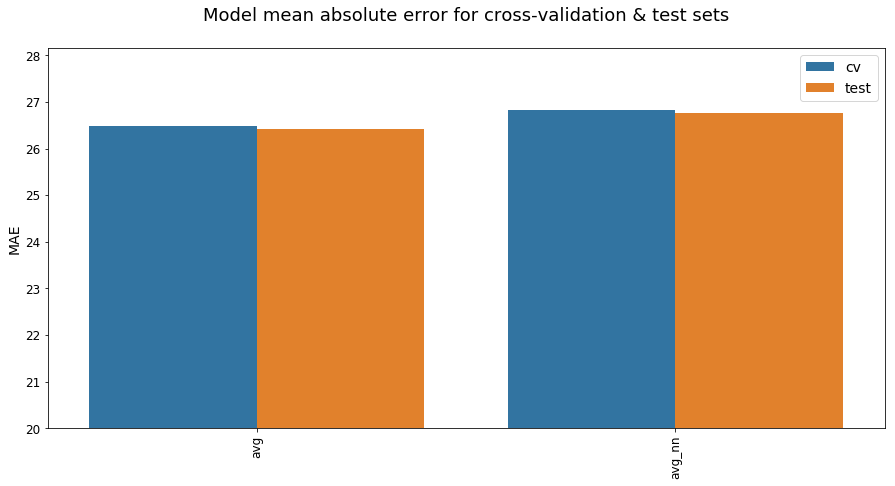

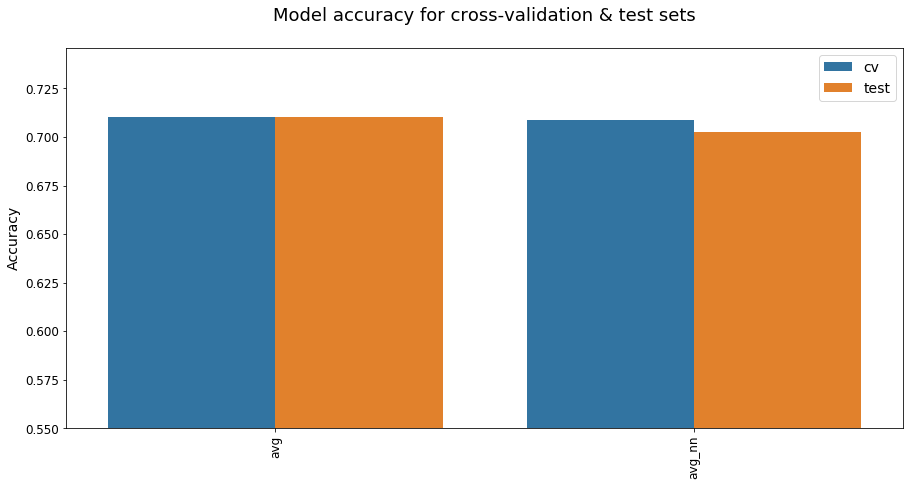

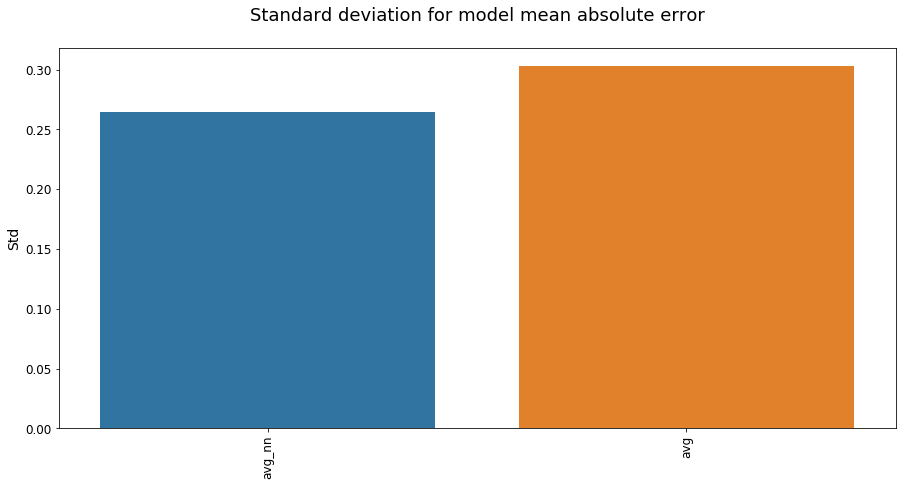

In [7]:
graph_cv_model_performance(scores)

In [10]:
YEAR_ESTIMATORS = [
    ('avg', avg_model, {}),
    ('avg_nn',
     nn_pipe,
     {'kerasregressor__callbacks': [callbacks.EarlyStopping(monitor='val_loss', patience=3)],
      'kerasregressor__verbose': 0})
]

year_scores = yearly_performance_scores(YEAR_ESTIMATORS, features, labels, parallel=False, data_frame=True)
year_scores

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 21969 samples, validate on 5493 samples
Epoch 1/20
21969/21969 [==============================] - 2s 99us/step - loss: 27.7259 - tip_accuracy: 0.6739 - val_loss: 27.3979 - val_tip_accuracy: 0.6969
Epoch 2/20
21969/21969 [==============================] - 2s 82us/step - loss: 26.6001 - tip_accuracy: 0.7048 - val_loss: 27.2635 - val_tip_accuracy: 0.6967
Epoch 3/20
21969/21969 [==============================] - 2s 90us/step - loss: 26.4392 - tip_accuracy: 0.7074 - val_loss: 27.1444 - val_tip_accuracy: 0.6954
Epoch 4/20
21969/21969 [==============================] - 2s 82us/step - loss: 26.3241 - tip_accuracy: 0.7080 - val_loss: 27.0727 - val_tip_accuracy: 0.6973
Epoch 5/20
21969/21969 [==============================] - 2s 70us/step - loss: 26.2522 - tip_accuracy: 0.7084 - val_loss: 27.2354 - val_tip_accuracy: 0.6989
Epoch 6/20
21969/21969 [==============================] - 2s 77us/step - loss: 26.1357 - tip_accuracy: 0.7093 - val_loss: 27.0671 - val_tip_accuracy: 0.6963
Epoch 7/2

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 22281 samples, validate on 5571 samples
Epoch 1/20
22281/22281 [==============================] - 3s 126us/step - loss: 27.6463 - tip_accuracy: 0.6857 - val_loss: 27.6307 - val_tip_accuracy: 0.6931
Epoch 2/20
22281/22281 [==============================] - 2s 99us/step - loss: 26.5951 - tip_accuracy: 0.7070 - val_loss: 27.2747 - val_tip_accuracy: 0.6970
Epoch 3/20
22281/22281 [==============================] - 2s 82us/step - loss: 26.4857 - tip_accuracy: 0.7062 - val_loss: 27.1788 - val_tip_accuracy: 0.6997
Epoch 4/20
22281/22281 [==============================] - 2s 79us/step - loss: 26.3403 - tip_accuracy: 0.7084 - val_loss: 27.1342 - val_tip_accuracy: 0.6952
Epoch 5/20
22281/22281 [==============================] - 2s 79us/step - loss: 26.2469 - tip_accuracy: 0.7093 - val_loss: 27.1702 - val_tip_accuracy: 0.6956
Epoch 6/20
22281/22281 [==============================] - 2s 78us/step - loss: 26.1699 - tip_accuracy: 0.7123 - val_loss: 27.0433 - val_tip_accuracy: 0.6943
Epoch 7/

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 22611 samples, validate on 5653 samples
Epoch 1/20
22611/22611 [==============================] - 3s 118us/step - loss: 27.6888 - tip_accuracy: 0.6828 - val_loss: 27.4202 - val_tip_accuracy: 0.6970
Epoch 2/20
22611/22611 [==============================] - 2s 81us/step - loss: 26.6830 - tip_accuracy: 0.7048 - val_loss: 27.1705 - val_tip_accuracy: 0.7037
Epoch 3/20
22611/22611 [==============================] - 2s 79us/step - loss: 26.5140 - tip_accuracy: 0.7098 - val_loss: 27.2277 - val_tip_accuracy: 0.6973
Epoch 4/20
22611/22611 [==============================] - 2s 82us/step - loss: 26.4225 - tip_accuracy: 0.7102 - val_loss: 27.3754 - val_tip_accuracy: 0.6956
Epoch 5/20
22611/22611 [==============================] - 2s 83us/step - loss: 26.2882 - tip_accuracy: 0.7079 - val_loss: 27.1887 - val_tip_accuracy: 0.7016
Epoch 6/20
22611/22611 [==============================] - 2s 81us/step - loss: 26.2065 - tip_accuracy: 0.7128 - val_loss: 27.3386 - val_tip_accuracy: 0.6952
Epoch 7/

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 22942 samples, validate on 5736 samples
Epoch 1/20
22942/22942 [==============================] - 3s 129us/step - loss: 27.5964 - tip_accuracy: 0.6841 - val_loss: 27.3914 - val_tip_accuracy: 0.6982
Epoch 2/20
22942/22942 [==============================] - 2s 89us/step - loss: 26.6825 - tip_accuracy: 0.7043 - val_loss: 27.3203 - val_tip_accuracy: 0.6968
Epoch 3/20
22942/22942 [==============================] - 2s 87us/step - loss: 26.5286 - tip_accuracy: 0.7081 - val_loss: 27.1940 - val_tip_accuracy: 0.7003
Epoch 4/20
22942/22942 [==============================] - 2s 87us/step - loss: 26.3921 - tip_accuracy: 0.7087 - val_loss: 27.1660 - val_tip_accuracy: 0.7010
Epoch 5/20
22942/22942 [==============================] - 3s 111us/step - loss: 26.2805 - tip_accuracy: 0.7118 - val_loss: 27.3362 - val_tip_accuracy: 0.6954
Epoch 6/20
22942/22942 [==============================] - 2s 105us/step - loss: 26.2309 - tip_accuracy: 0.7112 - val_loss: 27.2026 - val_tip_accuracy: 0.7028
Epoch 

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 23273 samples, validate on 5819 samples
Epoch 1/20
23273/23273 [==============================] - 3s 136us/step - loss: 27.7043 - tip_accuracy: 0.6884 - val_loss: 27.2144 - val_tip_accuracy: 0.7017
Epoch 2/20
23273/23273 [==============================] - 2s 91us/step - loss: 26.7091 - tip_accuracy: 0.7036 - val_loss: 27.2171 - val_tip_accuracy: 0.6977
Epoch 3/20
23273/23273 [==============================] - 2s 105us/step - loss: 26.5837 - tip_accuracy: 0.7086 - val_loss: 27.4374 - val_tip_accuracy: 0.6955
Epoch 4/20
23273/23273 [==============================] - 3s 108us/step - loss: 26.4892 - tip_accuracy: 0.7072 - val_loss: 27.3143 - val_tip_accuracy: 0.7003
Epoch 5/20
23273/23273 [==============================] - 3s 109us/step - loss: 26.3596 - tip_accuracy: 0.7116 - val_loss: 27.3170 - val_tip_accuracy: 0.7006
Epoch 6/20
23273/23273 [==============================] - 2s 92us/step - loss: 26.2803 - tip_accuracy: 0.7115 - val_loss: 27.0838 - val_tip_accuracy: 0.6998
Epoch

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

Train on 23603 samples, validate on 5901 samples
Epoch 1/20
23603/23603 [==============================] - 3s 145us/step - loss: 27.7286 - tip_accuracy: 0.6873 - val_loss: 27.3400 - val_tip_accuracy: 0.7012
Epoch 2/20
23603/23603 [==============================] - 2s 94us/step - loss: 26.7827 - tip_accuracy: 0.7029 - val_loss: 27.4114 - val_tip_accuracy: 0.7023
Epoch 3/20
23603/23603 [==============================] - 2s 93us/step - loss: 26.6062 - tip_accuracy: 0.7077 - val_loss: 27.2975 - val_tip_accuracy: 0.6999
Epoch 4/20
23603/23603 [==============================] - 2s 92us/step - loss: 26.5298 - tip_accuracy: 0.7093 - val_loss: 27.1670 - val_tip_accuracy: 0.7028
Epoch 5/20
23603/23603 [==============================] - 2s 94us/step - loss: 26.4527 - tip_accuracy: 0.7128 - val_loss: 27.2881 - val_tip_accuracy: 0.7001
Epoch 6/20
23603/23603 [==============================] - 2s 93us/step - loss: 26.3278 - tip_accuracy: 0.7110 - val_loss: 27.3342 - val_tip_accuracy: 0.7017
Epoch 7/

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown

,accuracy,error,model,year
0,0.746154,29.457558,avg,2011
1,0.720513,30.330299,avg_nn,2011
2,0.774272,28.045074,avg,2012
3,0.762136,29.374311,avg_nn,2012
4,0.714976,26.830137,avg,2013
5,0.736715,27.436588,avg_nn,2013
6,0.724638,28.777830,avg,2014
7,0.736715,29.294245,avg_nn,2014
8,0.716019,30.183555,avg,2015
9,0.733010,30.013413,avg_nn,2015


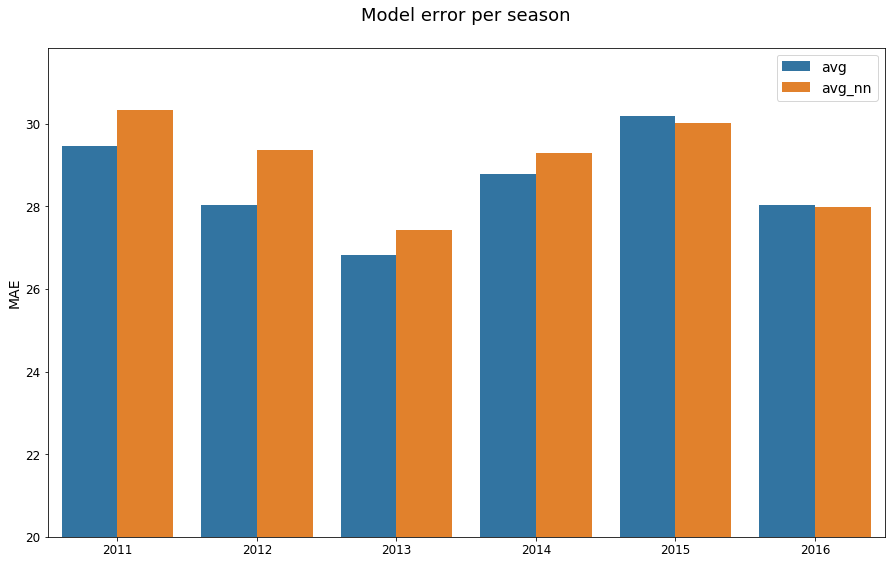

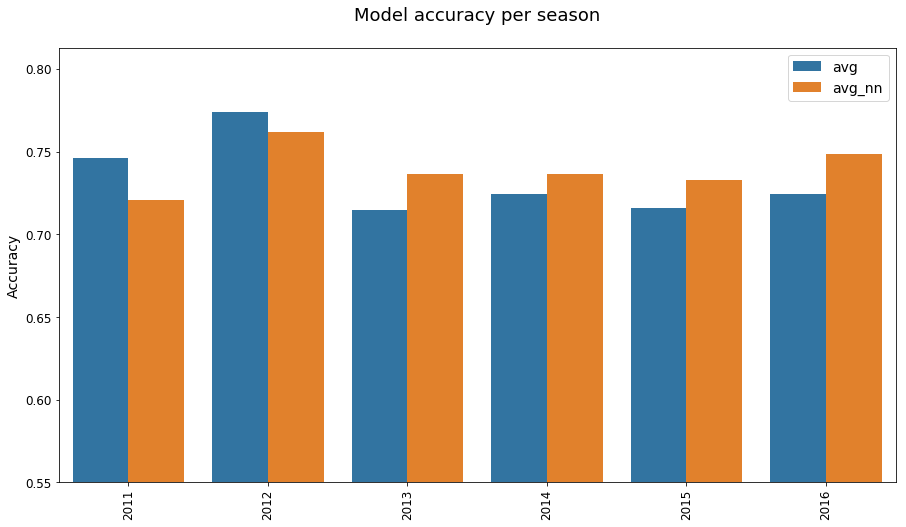

In [11]:
graph_yearly_model_performance(year_scores)

In [12]:
year_scores.groupby('model').mean()

,accuracy,error,year
model,,,
avg,0.733449,28.553390,2013.5
avg_nn,0.739647,29.074205,2013.5


In [13]:
year_scores.groupby('model').std()

,accuracy,error,year
model,,,
avg,0.022927,1.185855,1.870829
avg_nn,0.014260,1.135066,1.870829


### Simple avg model performs a little better
The yearly accuracy for the model with the NN is a little better, but the basic avg model performs better across all other metrics and has a much faster training time, so I'll leave out the NN for now.